In [1]:
!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = file_path = r'C:\Users\Rahul\Desktop\CloudWatch_Traffic_Web_Attack.csv'

df = pd.read_csv(file_path)

# Display basic info and the first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

(None,
    bytes_in  bytes_out         creation_time              end_time  \
 0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
 1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
 2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
 3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
 4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
 
             src_ip src_ip_country_code protocol  response.code  dst_port  \
 0   147.161.161.82                  AE    HTTPS            200       443   
 1     165.225.33.6                  US    HTTPS            200       443   
 2  165.225.212.255                  CA    HTTPS            200       443   
 3   136.226.64.114                  US    HTTPS            200       443   
 4   165.225.240.79                  NL    HTTPS            200       443   
 
          dst_ip              rule_names                      observation_name  \
 0  10.138.69.97  S

In [3]:
# Convert time columns to datetime format
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Feature Engineering: Calculate session duration
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Data Cleaning: Remove duplicates
df = df.drop_duplicates()

# Standardization of numerical columns
scaler = StandardScaler()
df[['bytes_in', 'bytes_out', 'session_duration']] = scaler.fit_transform(
    df[['bytes_in', 'bytes_out', 'session_duration']]
)

In [4]:
 # One-hot Encoding for categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['src_ip_country_code']])
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df.index)
df = pd.concat([df, encoded_df], axis=1)

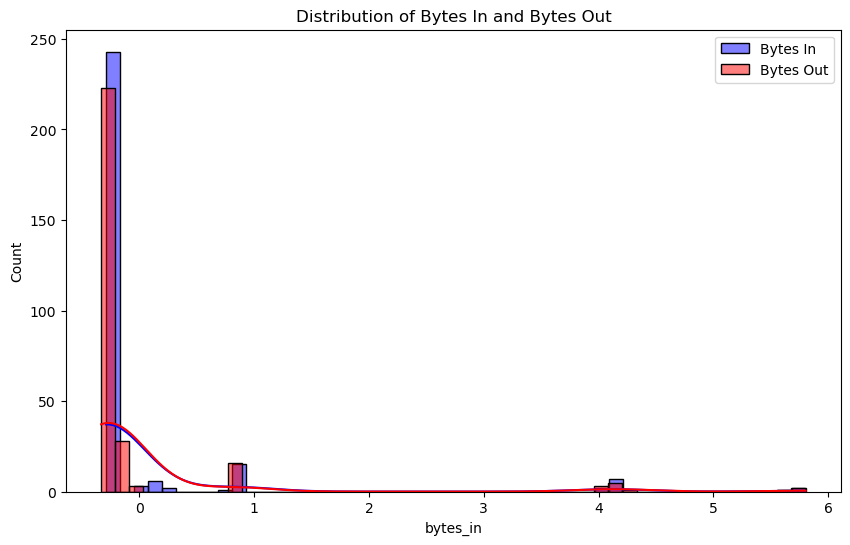

In [5]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.histplot(df['bytes_in'], bins=50, kde=True, color='blue', label='Bytes In')
sns.histplot(df['bytes_out'], bins=50, kde=True, color='red', label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.show()

In [6]:
# Anomaly Detection using Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = isolation_forest.fit_predict(df[['bytes_in', 'bytes_out', 'session_duration']])
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

In [7]:
# Classification using RandomForest
X = df[['bytes_in', 'bytes_out', 'session_duration']]
y = (df['detection_types'] == 'waf_rule').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))

Random Forest Accuracy: 1.0
Classification Report:               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [8]:
# Neural Network for Threat Detection
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_split=0.2)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9913 - loss: 0.6384 - val_accuracy: 1.0000 - val_loss: 0.5104
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.5148 - val_accuracy: 1.0000 - val_loss: 0.3732
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.3667 - val_accuracy: 1.0000 - val_loss: 0.2372
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.2330 - val_accuracy: 1.0000 - val_loss: 0.1246
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1248 - val_accuracy: 1.0000 - val_loss: 0.0577
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0583 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 1.0000 - v

In [9]:
# Evaluate Neural Network
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network Test Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0059
Neural Network Test Accuracy: 100.00%
